Scratch pad to develop the dynamically-constrained super-resolution training pipeline. 

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import jax
import jax.numpy as jnp
import numpy as np

import keras
import jax_cfd.base as cfd
import jax_cfd.spectral as spectral

from typing import Callable

In [5]:
# setup problem and create grid
Lx = 2 * jnp.pi
Ly = 2 * jnp.pi
Nx = 128
Ny = 128
Re = 40.

grid = cfd.grids.Grid((Nx, Ny), domain=((0, Lx), (0, Ly)))

# estimate stable time step based on a "max velocity" using CFL condition
max_vel_est = 5.
dt_stable = cfd.equations.stable_time_step(max_vel_est, 0.5, 1./Re, grid) / 2.

First point to the data (small trajectories) and view to make sure appearance is realistic

In [6]:
data_loc = '/Users/jpage2/code/jax-cfd-data-gen/Re40superres/'
file_front = 'vort_short_traj.'
n_zeros = 5 

In [54]:
# add a new axis for "channels" and a new axis for "batch" (at front)
vort_example_traj = np.load(data_loc + file_front + str(70).zfill(5) + '.npy')[np.newaxis, :, :, :,np.newaxis]
vort_example_traj.shape

(1, 10, 128, 128, 1)

In [55]:
def average_pool_trajectory(omega_traj, pool_width, pool_height):
  batch_size, trajectory_length, Nx, Ny, Nchannels = omega_traj.shape
  assert Nx % pool_width == 0
  assert Ny % pool_height == 0

  omega_reshaped = omega_traj.reshape(
    (batch_size, trajectory_length, Nx // pool_width, pool_width, Ny // pool_height, pool_height, Nchannels)
  )
  omega_pooled_traj = omega_reshaped.mean(axis=(3, 5))
  return omega_pooled_traj

pooling_fn = jax.jit(average_pool_trajectory, static_argnums=(1, 2))


In [116]:
filter_size = 32
vort_traj_pooled = pooling_fn(vort_example_traj, filter_size, filter_size)

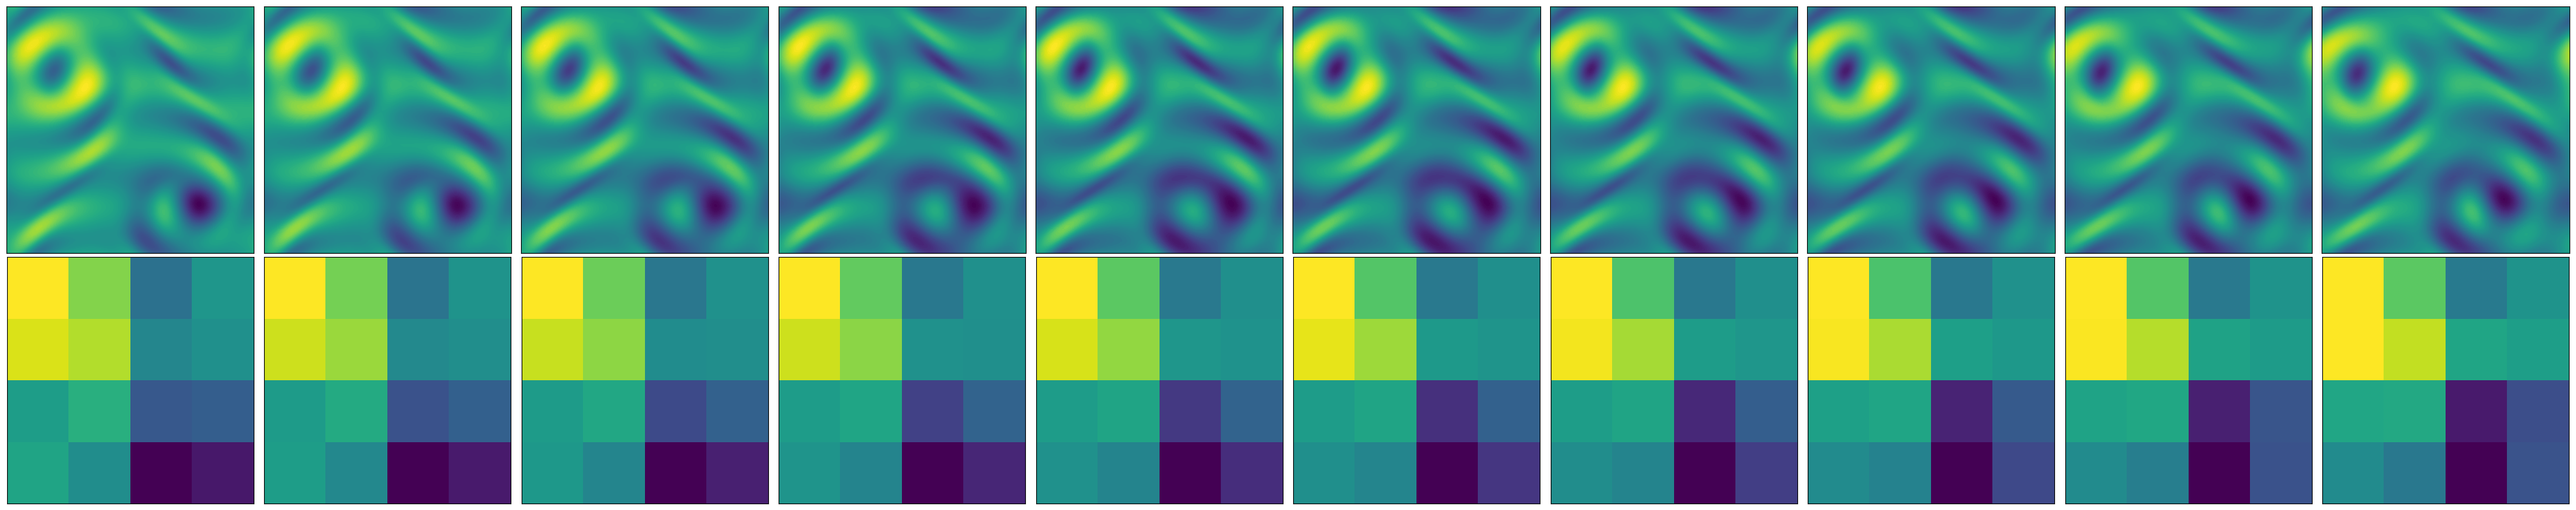

In [117]:
vort_traj_plot = jnp.squeeze(vort_example_traj)
vort_coarse_plot = jnp.squeeze(vort_traj_pooled)

import matplotlib.pyplot as plt

num_axes = len(vort_traj_plot)

fig = plt.figure(figsize=(4 * num_axes, 8))
ax_num = 1
for vort, vort_coarse in zip(vort_traj_plot, vort_coarse_plot):
  ax = fig.add_subplot(2, num_axes, ax_num)
  ax.contourf(vort.T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, num_axes, ax_num + num_axes)
  ax.imshow(vort_coarse.T, origin='lower')
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()

Let's build the ResNet-type model we will use to perform super resolution. The model should simply operate on batches of images, we need the loss (and data loading) to see the full trajectory though.

In [118]:
from models import periodic_convolution
from keras.layers import BatchNormalization, Activation, UpSampling2D

def residual_block_periodic_conv(x, n_filters,
                                 kernel=(1,1), strides=(1,1),
                                 n_pad_rows=1, n_pad_cols=1,
                                 activation='gelu'):
  layer_input = x 

  # number of filters must match input = x.shape[-1]
  n_filters = x.shape[-1]

  x = BatchNormalization()(x)
  x = Activation(activation)(x)

  x = periodic_convolution(x, n_filters, kernel, strides=strides,
                           n_pad_rows=n_pad_rows, n_pad_cols=n_pad_cols, activation=activation)
  
  x = BatchNormalization()(x)

  x = periodic_convolution(x, n_filters, kernel, strides=strides,
                           n_pad_rows=n_pad_rows, n_pad_cols=n_pad_cols, activation='linear')

  x = keras.layers.add([x, layer_input])
  return x

In [192]:
from keras.layers import Input 
from keras.models import Model

def super_res_v0(Nx_coarse, Ny_coarse, N_filters, N_grow=4):
  """ Build a model to perform super-resolution, scaling up N_grow times.  """
  input_vort = Input(shape=(Nx_coarse, Ny_coarse, 1))
   
  # an initial linear layer prior to Residual blocks 
  x = periodic_convolution(input_vort, N_filters, kernel=(4, 4),
                           n_pad_rows=3, n_pad_cols=3, activation='linear')
  
  # upsample and apply residual block however many times we need to rescale 
  # note we are keeping our kernel constant size -- perhaps not ideal
  # might want to scale this too 
  for _ in range(N_grow):
    x = UpSampling2D((2,2))(x)
    x = residual_block_periodic_conv(x, N_filters, kernel=(4,4),
                                     n_pad_rows=3, n_pad_cols=3)
  
  x = periodic_convolution(x, 1, kernel=(4, 4),
                           n_pad_rows=3, n_pad_cols=3, activation='linear')
  return Model(input_vort, x)

In [193]:
super_model = super_res_v0(Nx // filter_size, Ny // filter_size, 32, N_grow=5)

In [194]:
super_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 4, 4, 1)   │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lambda_60 (Lambda)  │ (None, 7, 7, 1)   │       0 │ input_layer_7[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 4, 4, 32)  │     544 │ lambda_60[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling2d_24    │ (None, 8, 8, 32)  │       0 │ conv2d_60[0][0]      │
│ (UpSampling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │     128 │ up_sampling2d_24[0]… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_24       │ (None, 8, 8, 32)  │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lambda_61 (Lambda)  │ (None, 11, 11,    │       0 │ activation_24[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 8, 8, 32)  │  16,416 │ lambda_61[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │     128 │ conv2d_61[0][0]      │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lambda_62 (Lambda)  │ (None, 11, 11,    │       0 │ batch_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 8, 8, 32)  │  16,416 │ lambda_62[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add_24 (Add)        │ (None, 8, 8, 32)  │       0 │ conv2d_62[0][0],     │
│                     │                   │         │ up_sampling2d_24[0]… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling2d_25    │ (None, 16, 16,    │       0 │ add_24[0][0]         │
│ (UpSampling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     128 │ up_sampling2d_25[0]… │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_25       │ (None, 16, 16,    │       0 │ batch_normalization… │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lambda_63 (Lambda)  │ (None, 19, 19,    │       0 │ activation_25[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 16,    │  16,416 │ lambda_63[0][0]      │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     128 │ conv2d_63[0][0]      │
│ (BatchNormalizatio… │ 32)               │         │                    

 Total params: 166,497 (650.38 KB)

 Trainable params: 165,857 (647.88 KB)

 Non-trainable params: 640 (2.50 KB)

Objective would be to initially pre-train this model on the pure reconstruction problem, prior to using the trajectory information in the loss.

Let's first verify we can run it on a small subset of the training data and train OK. 

Slightly awkward since we ultimately want to train on batches of trajectories, so for our initial tests involves some awkward reshaping

In [195]:
vort_snapshots = jnp.array([np.load(data_loc + file_front + str(n).zfill(5) + '.npy')[np.newaxis, 0, :, :,np.newaxis] for n in range(1000)])
vort_snapshots_coarse = average_pool_trajectory(vort_snapshots, filter_size, filter_size)

vort_snapshots = vort_snapshots[:, 0]
vort_snapshots_coarse = vort_snapshots_coarse[:, 0]

In [196]:
vort_snapshots_coarse.shape
# vort_snapshots.shape

(1000, 4, 4, 1)

In [200]:
# train a few epochs on standard MSE prior to unrolling
super_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss='mse', 
    metrics=[keras.losses.MeanSquaredError()]
)
super_model.fit(vort_snapshots_coarse, vort_snapshots, batch_size=16, epochs=2)

TypeError: Exception encountered when calling Conv2D.call().

[1m'NoneType' object is not callable[0m

Arguments received by Conv2D.call():
  • inputs=jnp.ndarray(shape=(16, 7, 7, 1), dtype=float32)

In [198]:
vort_snapshots_test = jnp.array([np.load(data_loc + file_front + str(n).zfill(5) + '.npy')[np.newaxis, 0, :, :,np.newaxis] for n in range(1000, 1050)])
vort_snapshots_coarse_test = average_pool_trajectory(vort_snapshots_test, filter_size, filter_size)

vort_snapshots_test = vort_snapshots_test[:, 0]
vort_snapshots_coarse_test = vort_snapshots_coarse_test[:, 0]

TypeError: 'NoneType' object is not callable

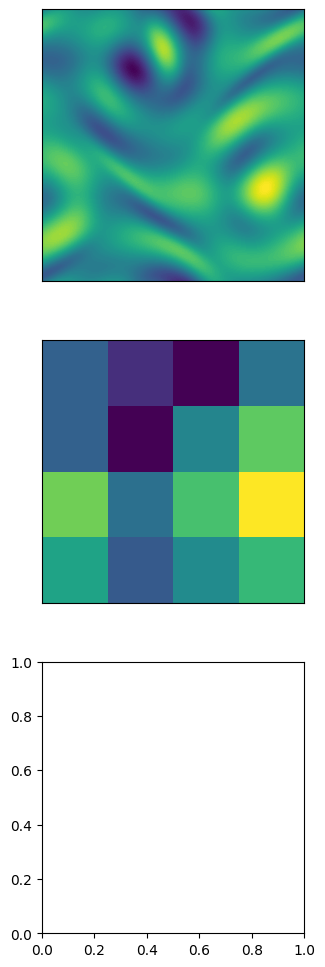

In [199]:
import matplotlib.pyplot as plt

num_axes = len(vort_traj_plot)

fig = plt.figure(figsize=(4 * num_axes, 12))
ax_num = 1
for vort, vort_coarse in zip(vort_snapshots_test[:10], vort_snapshots_coarse_test[:10]):
  ax = fig.add_subplot(3, num_axes, ax_num)
  ax.contourf(vort[:, :, 0].T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, num_axes, ax_num + num_axes)
  ax.imshow(vort_coarse[:, :, 0].T, origin='lower')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, num_axes, ax_num + 2 * num_axes)
  vort_pred = super_model.predict(vort_coarse.reshape(
    (1, Nx // filter_size, Ny // filter_size, 1))
    )
  
  rel_error = jnp.linalg.norm(vort_pred.flatten() - vort.flatten()) / jnp.linalg.norm(vort_pred.flatten())
  print(rel_error)

  # print(jnp.mean((vort_pred.reshape((Nx, Ny)) - vort[:, :, 0]) ** 2))

  ax.contourf(vort_pred[0, :, :, 0].T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()

We have basic functionality and a resonable model. Need to compare exactly the same metric as Taira (note relative error on vorticity; also different problem). Might help if we can mimick the decaying calculations he has done (or push them up in Re). 

Model is small enough that there is scope to really play around with filter sizes etc. 

In [186]:
def mse_and_traj_coarsen(
    vort_true: jnp.ndarray, 
    vort_pred: jnp.ndarray, 
    trajectory_rollout_fn: Callable[[jnp.ndarray], jnp.ndarray]
    ):
    # ,
    # coarsen_fn: Callable[[jnp.ndarray], jnp.ndarray]
    # ):
  """ Trajectory fn expects real input and gives real output (i.e. fields in physical space)"""
  squared_errors_recon = (vort_true - vort_pred) ** 2

  # NB vort has been normalized by vort_max for prediction
  true_traj = trajectory_rollout_fn(vort_true)
  pred_traj = trajectory_rollout_fn(vort_pred)

  # we then coarsen back down and compute the errors on the coarsened field
  # i.e. do not require high-fidelity recon (perhaps revisit)
  squared_errors_traj = (true_traj - pred_traj) ** 2
  return 0.5 * jnp.mean(squared_errors_recon) + 0.5 * jnp.mean(squared_errors_traj)

In [187]:
dt_stable = np.round(dt_stable, 3)
dt_stable

0.002

In [190]:
from functools import partial
import time_stepping as ts

T_unroll = 2.5

# generate a trajectory function
trajectory_fn = ts.generate_trajectory_fn(Re, T_unroll + 1e-2, dt_stable, grid, t_substep=0.5)

# wrap trajectory function with FFTs to enable physical space -> physical space map
def real_to_real_traj_fn(vort_phys, traj_fn):
  vort_rft = jnp.fft.rfftn(vort_phys, axes=(1,2))[...,0]
  _, traj_rft = traj_fn(vort_rft)
  traj_phys = jnp.fft.irfftn(traj_rft, axes=(1,2))[...,jnp.newaxis]
  return traj_phys

# pooling_fn = jax.jit(partial(average_pool_trajectory, pool_width=filter_size, pool_height=filter_size))
real_traj_fn = partial(real_to_real_traj_fn, traj_fn=jax.vmap(trajectory_fn))
loss_fn = jax.jit(partial(mse_and_traj_coarsen, trajectory_rollout_fn=real_traj_fn)) #, coarsen_fn=pooling_fn))

In [191]:
super_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss=loss_fn, 
    metrics=[keras.losses.MeanSquaredError()]
)
super_model.fit(vort_snapshots_coarse, vort_snapshots, batch_size=16, epochs=5)

TypeError: Exception encountered when calling Conv2D.call().

[1m'NoneType' object is not callable[0m

Arguments received by Conv2D.call():
  • inputs=jnp.ndarray(shape=(16, 7, 7, 1), dtype=float32)

In [176]:
loss_fn(vort_snapshots_coarse)

<PjitFunction of functools.partial(<function mse_and_traj_coarsen at 0x324e1f4c0>, trajectory_rollout_fn=<function <unnamed function> at 0x148198860>)>